# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [2]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

2.8 CUDA

Question 2: How much memory does the graphics card have?

24GB

Question 3: What is stored in the GPU memory while training a DNN ?

-parameters : weights as well as bias

-Temporary memory for local variables of kernel implementations

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [3]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)

X= X[:, 24:]
print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class


The covariates have size (764137, 92).
The labels have size (764137,).


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [4]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

print(np.isnan(X).any())
print(np.isnan(Y).any())

# Print the number of NaNs (not a number) in the labels
print(np.count_nonzero(np.isnan(X)))

# Print the number of NaNs in the covariates
print(np.count_nonzero(np.isnan(Y)))


False
False
0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [5]:
# Convert covariates to floats
X = np.array(X,dtype = float)

# Convert labels to integers
Y= np.array(Y, dtype = int)

Xrows, Xcolumns = X.shape

# Remove mean of each covariate (column)
for col in range(Xcolumns):
    mean = np.mean(X[:,col])
    for row in range(Xrows):
        X[row, col] -= mean

# Divide each covariate (column) by its standard deviation
for col in range(Xcolumns):
    stddev = np.std(X[:,col])
    for row in range(Xrows):
        X[row, col] /= stddev

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
meanVals = []
stddevVals= []
for col in range(Xcolumns):
    meanVals.append(round(np.mean(X[:,col]),6))
    stddevVals.append(round(np.std(X[:,col]),6))

print(meanVals)
print(stddevVals)
#print(sum(meanVals))
#print(sum(stddevVals))

[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [6]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=123)


print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
TrainClasses, TrainCounts = np.unique(Ytrain, return_counts=True)
TempClasses, TempCounts = np.unique(Ytemp, return_counts=True)

print("Training Data Label counts:")
for label, count in zip(TrainClasses, TrainCounts):
    print(f"{label} occurs {count} times")

print("Temporary Data Label counts:")
for label, count in zip(TempClasses, TempCounts):
    print(f"{label} occurs {count} times")

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Training Data Label counts:
0 occurs 85249 times
1 occurs 449646 times
Temporary Data Label counts:
0 occurs 36372 times
1 occurs 192870 times


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [7]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=12)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [8]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import CategoricalCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)
import random

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.1,
              use_bn=False, use_dropout=False, use_custom_dropout=False, dropoutRate=0.5):

    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add(Input(shape=(input_shape[1],)))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
      if use_bn == False:
            model.add(Dense(n_nodes, activation=act_fun))
      if use_bn == True:
            model.add(Dense(n_nodes, activation=act_fun))
            model.add(BatchNormalization())

            if use_dropout == True:
                if dropoutRate > 0 and dropoutRate < 1 :
                    model.add(Dropout(rate=dropoutRate))

            if use_custom_dropout == True:
                custom_dropout = 0.5
                model.add(myDropout(custom_dropout))
                
        
    # Add final layer
    model.add(Dense(1,activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [9]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):

    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [19]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = X.shape

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20)

#Printing the model summary
model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval))

Epoch 1/20


2024-04-23 16:18:43.702900: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196841360 exceeds 10% of free system memory.


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8389 - loss: 0.5710 - val_accuracy: 0.8403 - val_loss: 0.4587
Epoch 2/20


2024-04-23 16:18:46.656624: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42180528 exceeds 10% of free system memory.


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8406 - loss: 0.4382 - val_accuracy: 0.8403 - val_loss: 0.3896
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8406 - loss: 0.3784 - val_accuracy: 0.8403 - val_loss: 0.3483
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8407 - loss: 0.3405 - val_accuracy: 0.8404 - val_loss: 0.3190
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8400 - loss: 0.3145 - val_accuracy: 0.8412 - val_loss: 0.2969
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8424 - loss: 0.2926 - val_accuracy: 0.8453 - val_loss: 0.2796
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8457 - loss: 0.2773 - val_accuracy: 0.8501 - val_loss: 0.2658
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8503 - loss: 0.2647 - val_accuracy: 0.8540 - val_loss: 0.2548
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8543 - loss: 0.2537 - val_accuracy: 0.8576 - val_loss: 0.2459
Epo

In [21]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest,Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.2028 
Test loss: 0.2031
Test accuracy: 0.8986


2024-04-23 16:19:24.997275: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42180528 exceeds 10% of free system memory.


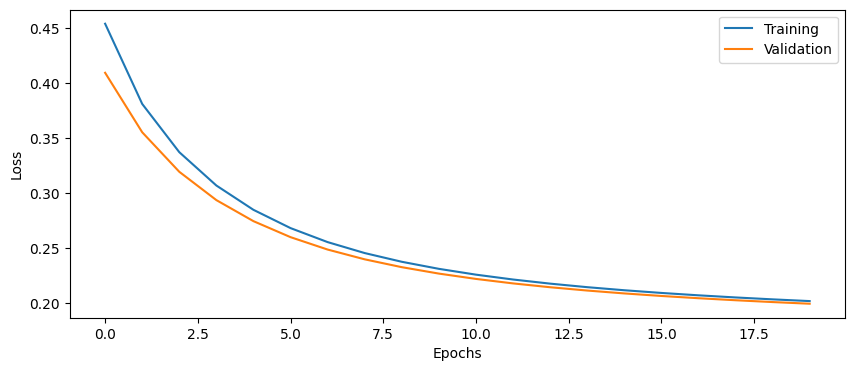

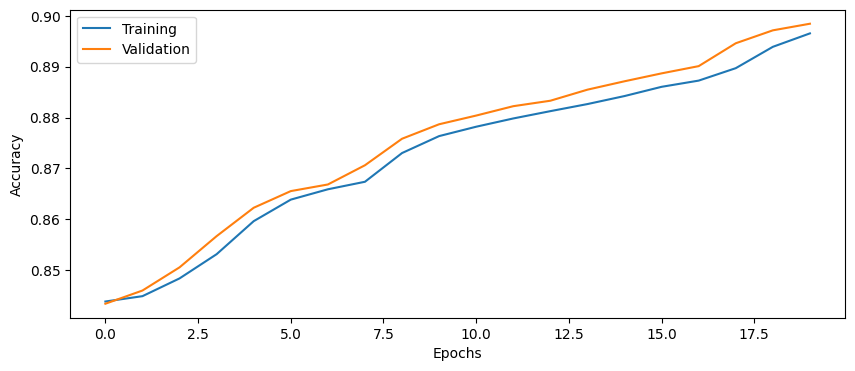

In [34]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

*Since Keras doesnot specify default activation functions the non specified dense layers will assume linear transformation. Thus adding several layers without specifying activation function does no good in improving the model.*

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

*By default the dense layer weights are initialised by glorot uniforn and the bias are intitialised to zeroes.*


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [10]:
from sklearn.utils import class_weight

# Calculate class weights

class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y) , y = Ytrain)


# Print the class weights
print(class_weights)
# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights,
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}


[3.13725088 0.59479568]


### 2 layers, 20 nodes, class weights

In [23]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model2 = build_DNN(input_shape, n_layers=2, n_nodes=20)

#Printing the model summary
print(model2.summary())

history2 = model1.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval),
                      class_weight=class_weights)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9013 - loss: 0.3544 - val_accuracy: 0.8962 - val_loss: 0.2122
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8934 - loss: 0.2855 - val_accuracy: 0.8937 - val_loss: 0.2267
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8918 - loss: 0.2593 - val_accuracy: 0.8910 - val_loss: 0.2388
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8886 - loss: 0.2466 - val_accuracy: 0.8886 - val_loss: 0.2476
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8859 - loss: 0.2397 - val_accuracy: 0.8874 - val_loss: 0.2537
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8851 - loss: 0.2352 - val_accuracy: 0.8867 - val_loss: 0.2579
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8848 - loss: 0.2318 - val_accuracy: 0.8863 - val_loss: 0.2605
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8847 - loss: 0.2295 - val_accuracy: 0.8862 - val_

In [24]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1541 - loss: 0.8746
Test loss: 0.8737
Test accuracy: 0.1555


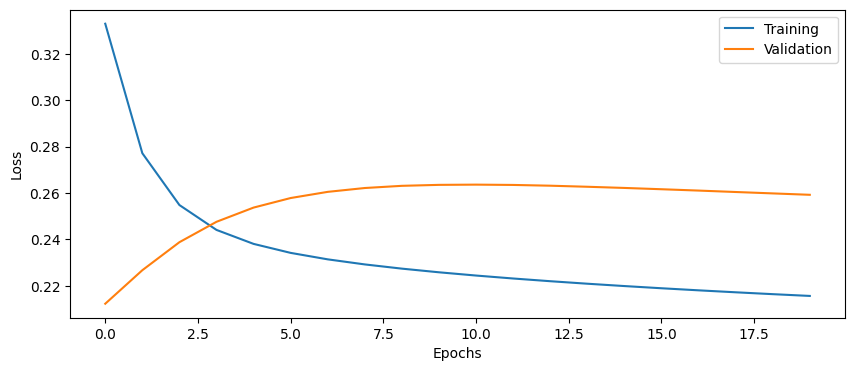

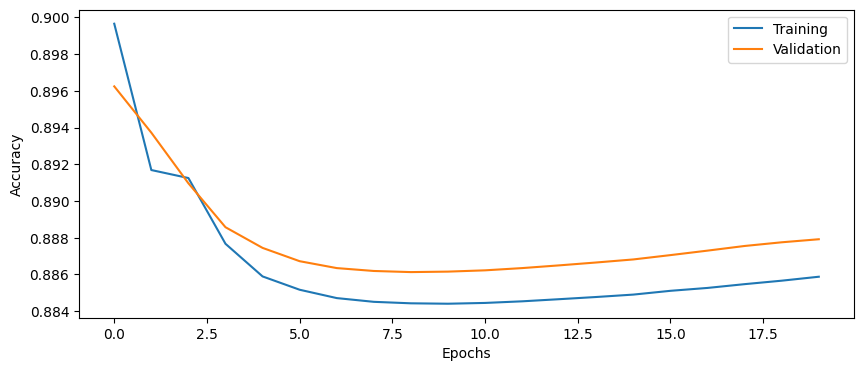

In [25]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

*Using the entire data at once increases the computational complexity of the model. it leads to memory constraints. Use of batch size will ease the memory burden on the system.*

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results.

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

*Number of weight updates per epoch in DNN= number of training examples / batch size*

*Number of Training examples = 534895*

*Weight update if batch size= 100 : 5348.95*

*Weight update if batch size= 1000 : 534.895*

*Weight update if batch size= 10000 : 53.4895*

Question 11: What limits how large the batch size can be?

*The limit of the batch size depends on the GPU/CPU memory, daa size, model complexity and so on*

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

*The learning rate should be reduced as the batch size is decreased as the weight updates are increased in case of smaller batch size which leads to increased noise ifluence*

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

*network with 4 dense layers with 50 nodes has 9801 trainable parameters*

*network with 2 layers and 20 nodes has 1881 trainable parameters*

In [20]:
print('Model with 2 layers and 20 nodes')
print(model1.summary())
model450 = build_DNN(input_shape, n_layers=4, n_nodes=50)
print('Model with 4 layers and 50 nodes')
model450.summary()

Model with 2 layers and 20 nodes


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Model with 4 layers and 50 nodes


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 50)             │         4,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,801 (38.29 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

### 4 layers, 20 nodes, class weights

In [27]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape

# Build and train model
model3 = build_DNN(input_shape, n_layers=4, n_nodes=20)

#Printing the model summary
print(model3.summary())

history3 = model3.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,721 (10.63 KB)

 Trainable params: 2,721 (10.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1590 - loss: 0.7807 - val_accuracy: 0.1597 - val_loss: 0.8578
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1594 - loss: 0.7094 - val_accuracy: 0.1597 - val_loss: 0.7545
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1589 - loss: 0.6954 - val_accuracy: 0.1597 - val_loss: 0.7164
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1598 - loss: 0.6939 - val_accuracy: 0.1598 - val_loss: 0.7011
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1612 - loss: 0.6919 - val_accuracy: 0.2554 - val_loss: 0.6949
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3997 - loss: 0.6911 - val_accuracy: 0.6670 - val_loss: 0.6918
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7263 - loss: 0.6898 - val_accuracy: 0.8043 - val_loss: 0.6902
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8120 - loss: 0.6902 - val_accuracy: 0.870

In [28]:
score = model3.evaluate(Xtest,Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8800 - loss: 0.6757
Test loss: 0.6757
Test accuracy: 0.8808


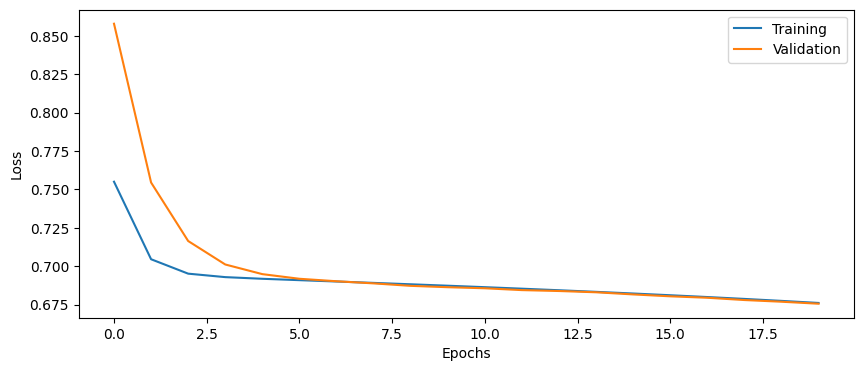

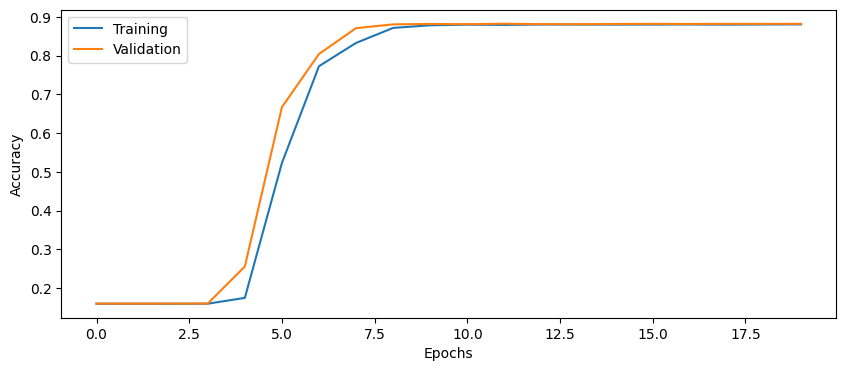

In [29]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [30]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
input_shape = X.shape

# Build and train model
model4 = build_DNN(input_shape, n_layers=2, n_nodes=50)

#Printing the model summary
print(model4.summary())

history4 = model4.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 50)             │         4,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,701 (18.36 KB)

 Trainable params: 4,701 (18.36 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8498 - loss: 0.6475 - val_accuracy: 0.8764 - val_loss: 0.5123
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8759 - loss: 0.4928 - val_accuracy: 0.8813 - val_loss: 0.4606
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8794 - loss: 0.4226 - val_accuracy: 0.8814 - val_loss: 0.4136
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8788 - loss: 0.3762 - val_accuracy: 0.8814 - val_loss: 0.3793
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8793 - loss: 0.3432 - val_accuracy: 0.8814 - val_loss: 0.3553
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8796 - loss: 0.3178 - val_accuracy: 0.8815 - val_loss: 0.3383
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8797 - loss: 0.3006 - val_accuracy: 0.8815 - val_loss: 0.3257
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8800 - loss: 0.2864 - val_accuracy: 0.881

In [31]:
# Evaluate model on test data
score = model4.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8834 - loss: 0.2751
Test loss: 0.2743
Test accuracy: 0.8839


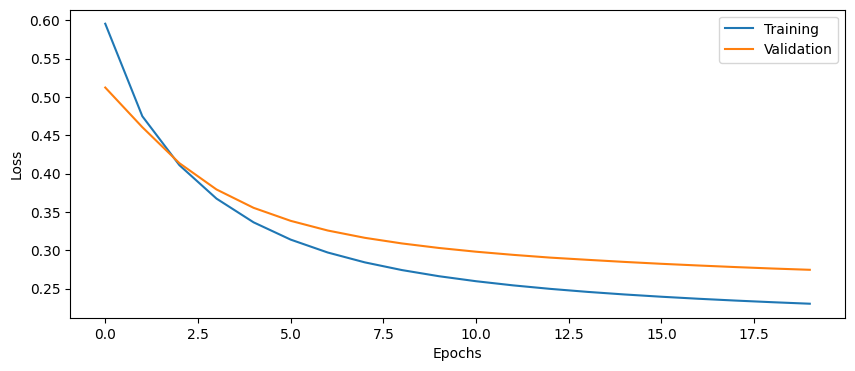

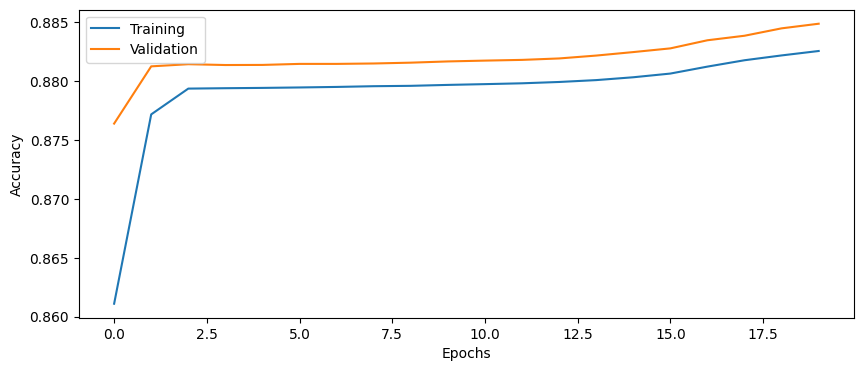

In [32]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [35]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
model5 = build_DNN(input_shape, n_layers=4, n_nodes=50)


#Printing the model summary
print(model5.summary())

history5 = model5.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 50)             │         4,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,801 (38.29 KB)

 Trainable params: 9,801 (38.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1595 - loss: 0.8362 - val_accuracy: 0.1597 - val_loss: 0.7716
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1588 - loss: 0.6923 - val_accuracy: 0.1603 - val_loss: 0.6988
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3423 - loss: 0.6883 - val_accuracy: 0.8645 - val_loss: 0.6887
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8651 - loss: 0.6876 - val_accuracy: 0.8756 - val_loss: 0.6843
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8736 - loss: 0.6841 - val_accuracy: 0.8816 - val_loss: 0.6837
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8795 - loss: 0.6824 - val_accuracy: 0.8832 - val_loss: 0.6826
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8812 - loss: 0.6804 - val_accuracy: 0.8832 - val_loss: 0.6816
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8821 - loss: 0.6783 - val_accuracy: 0.885

In [36]:
# Evaluate model on test data
score = model5.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8834 - loss: 0.6442
Test loss: 0.6441
Test accuracy: 0.8842


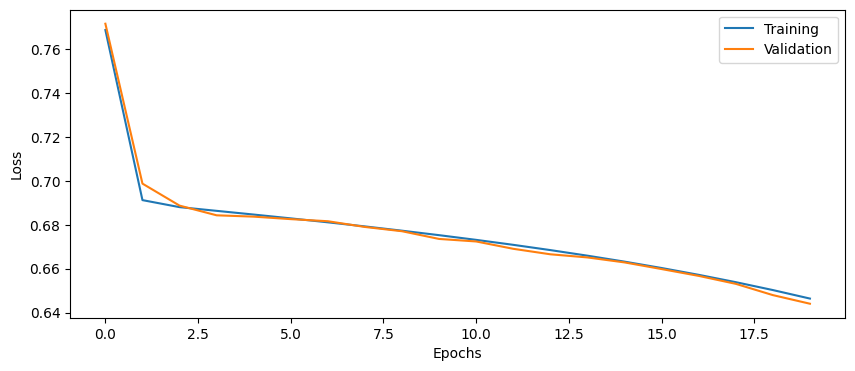

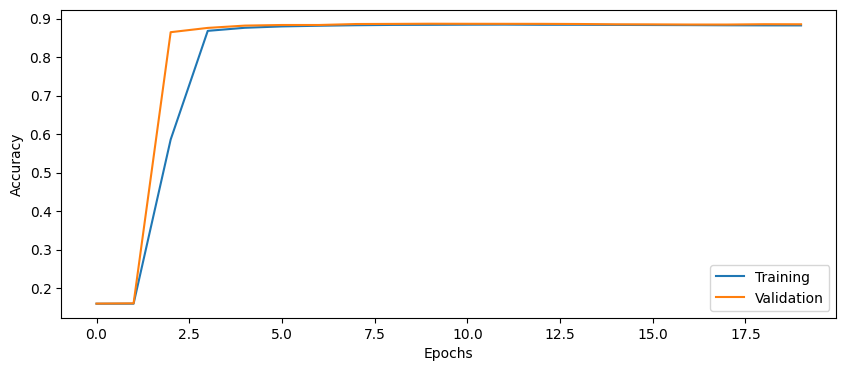

In [37]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers.

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

*It helps in faster training of the models. Batch normalization regulates the values going into each activation function which makes the non-linearlities become more viable making the modeling efficient. it also removes biases over batch dimensions which helps the network in easily identifying the differences between features and thus increasing accuracy.*

### 2 layers, 20 nodes, class weights, batch normalization

In [38]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
model6 = build_DNN(input_shape, n_layers=2, n_nodes=20, use_bn = True)

#Printing the model summary
print(model6.summary())


history6 = model6.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,961 (7.66 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 40 (160.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8091 - loss: 0.4705 - val_accuracy: 0.8565 - val_loss: 0.4200
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8789 - loss: 0.3285 - val_accuracy: 0.8805 - val_loss: 0.3916
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8827 - loss: 0.3032 - val_accuracy: 0.9034 - val_loss: 0.3636
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8862 - loss: 0.2845 - val_accuracy: 0.9081 - val_loss: 0.3367
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8903 - loss: 0.2697 - val_accuracy: 0.9060 - val_loss: 0.3150
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8941 - loss: 0.2583 - val_accuracy: 0.9042 - val_loss: 0.3009
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8964 - loss: 0.2492 - val_accuracy: 0.9030 - val_loss: 0.2942
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8973 - loss: 0.2404 - val_accuracy: 0.902

In [39]:
# Evaluate model on test data
score = model6.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9070 - loss: 0.2663 
Test loss: 0.2655
Test accuracy: 0.9074


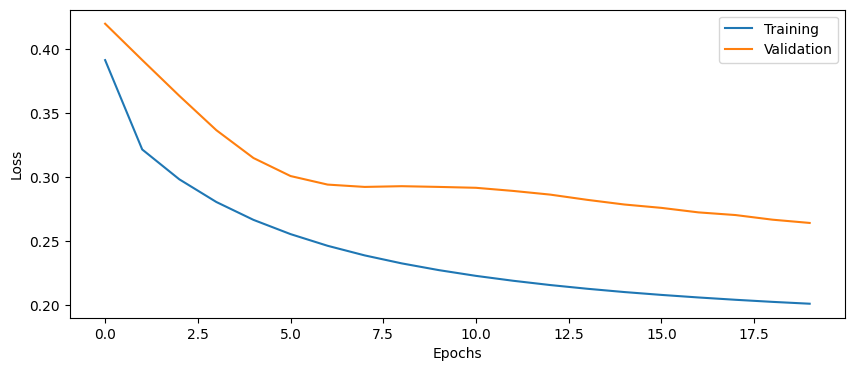

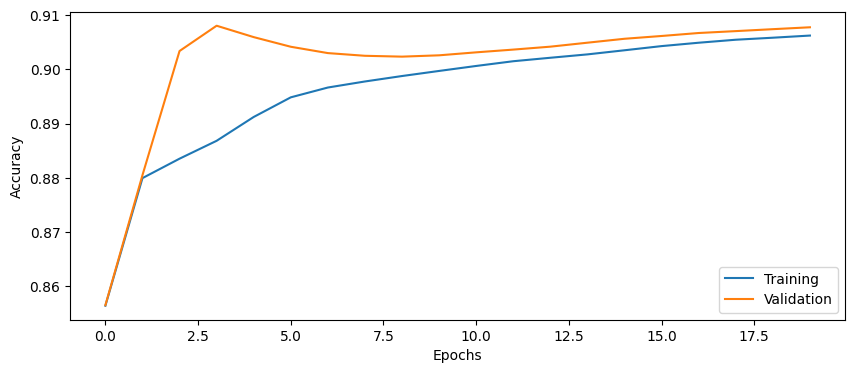

In [40]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [41]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
model7 = build_DNN(input_shape, n_layers=2, n_nodes=20, act_fun = 'relu')

#Printing the model summary
print(model7.summary())

history7 = model7.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8612 - loss: 0.4470 - val_accuracy: 0.8771 - val_loss: 0.4562
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8770 - loss: 0.3391 - val_accuracy: 0.8828 - val_loss: 0.3981
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8825 - loss: 0.3004 - val_accuracy: 0.8861 - val_loss: 0.3589
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8850 - loss: 0.2729 - val_accuracy: 0.8882 - val_loss: 0.3324
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8876 - loss: 0.2578 - val_accuracy: 0.8898 - val_loss: 0.3138
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8886 - loss: 0.2465 - val_accuracy: 0.8910 - val_loss: 0.3011
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8893 - loss: 0.2366 - val_accuracy: 0.8919 - val_loss: 0.2907
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8906 - loss: 0.2287 - val_accuracy: 0.8925 - val

In [42]:
# Evaluate model on test data
score = model7.evaluate(Xtest,Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8988 - loss: 0.2499 
Test loss: 0.2485
Test accuracy: 0.8992


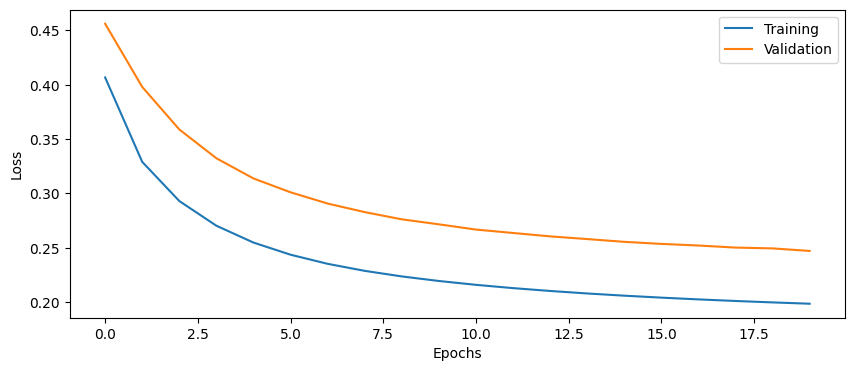

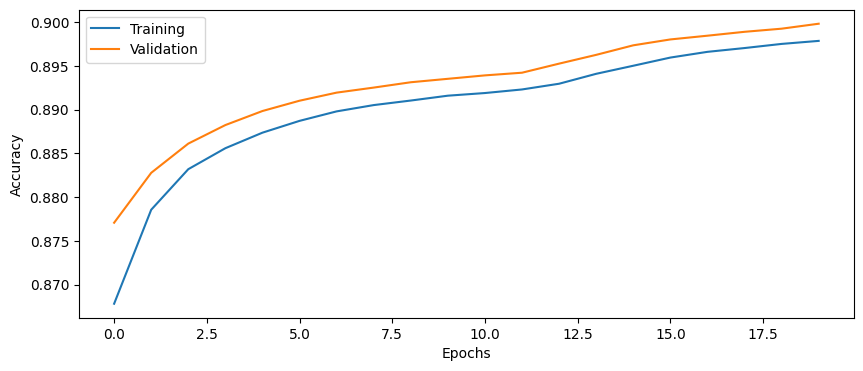

In [43]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers.

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [46]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
model8 = build_DNN(input_shape, n_layers=2, n_nodes=20, optimizer='adam')

#Printing the model summary
print(model8.summary())

history8 = model8.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8622 - loss: 0.3750 - val_accuracy: 0.8928 - val_loss: 0.2481
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8959 - loss: 0.1958 - val_accuracy: 0.9075 - val_loss: 0.2288
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9074 - loss: 0.1785 - val_accuracy: 0.9120 - val_loss: 0.2173
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9115 - loss: 0.1720 - val_accuracy: 0.9151 - val_loss: 0.2160
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9144 - loss: 0.1676 - val_accuracy: 0.9162 - val_loss: 0.2079
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9148 - loss: 0.1652 - val_accuracy: 0.9166 - val_loss: 0.2017
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9151 - loss: 0.1632 - val_accuracy: 0.9175 - val_loss: 0.2002
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9159 - loss: 0.1618 - val_accuracy: 0.9179 - val

In [47]:
# Evaluate model on test data
score = model8.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9195 - loss: 0.1820 
Test loss: 0.1815
Test accuracy: 0.9199


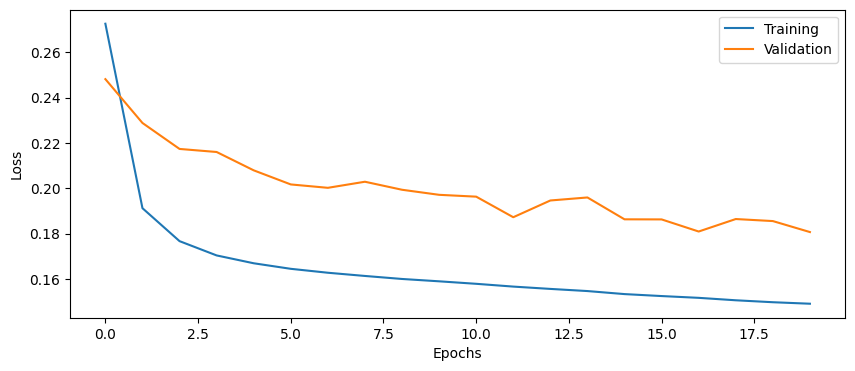

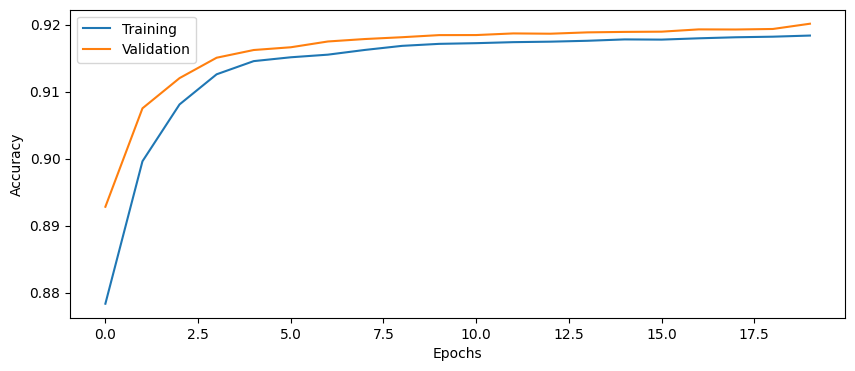

In [48]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

*The validation accuracy will increase by adding dropout*

Question 16: How does the test accuracy change when adding dropout?

*The test Accuracy shows improvement by adding dropout*

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [49]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = X.shape

# Build and train model
model9 = build_DNN(input_shape, n_layers=2, n_nodes=20 ,use_dropout=True)

#Printing the model summary
print(model9.summary())

history9 = model9.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval,Yval), class_weight=class_weights)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (7.35 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1485 - loss: 0.7393 - val_accuracy: 0.6595 - val_loss: 0.6845
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7881 - loss: 0.6074 - val_accuracy: 0.8764 - val_loss: 0.5888
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8772 - loss: 0.5201 - val_accuracy: 0.8830 - val_loss: 0.5178
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8817 - loss: 0.4580 - val_accuracy: 0.8851 - val_loss: 0.4658
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8825 - loss: 0.4122 - val_accuracy: 0.8858 - val_loss: 0.4274
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8838 - loss: 0.3779 - val_accuracy: 0.8863 - val_loss: 0.3983
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8840 - loss: 0.3514 - val_accuracy: 0.8864 - val_loss: 0.3761
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8836 - loss: 0.3310 - val_accuracy: 0.8866 - val

In [50]:
# Evaluate model on test data
score = model9.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8870 - loss: 0.2870 
Test loss: 0.2861
Test accuracy: 0.8875


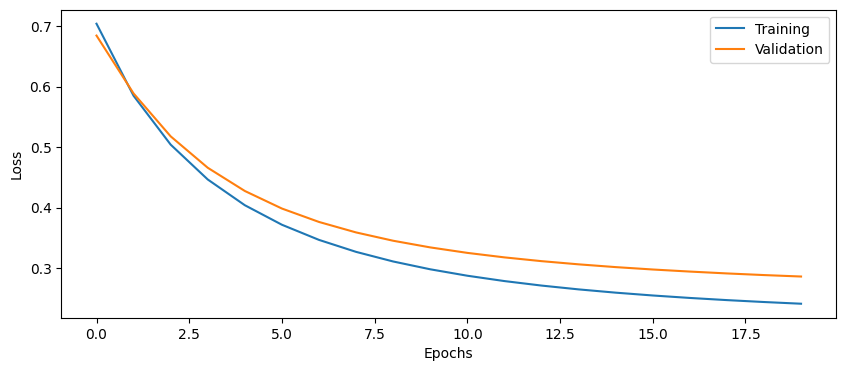

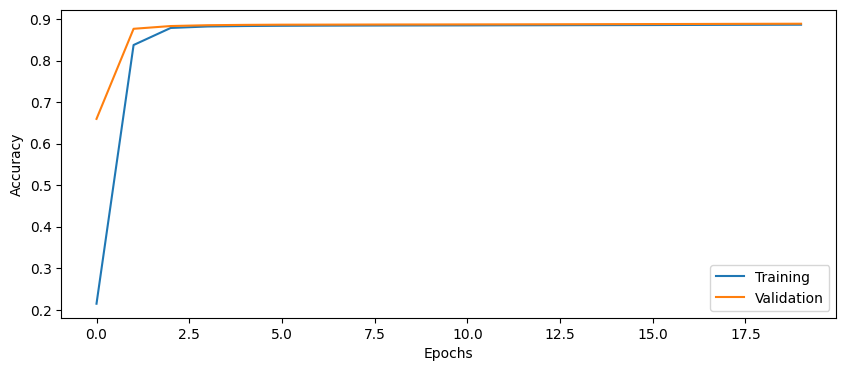

In [51]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

*Highest Test accuracy: 0.9268*

*Best Configuration:*

 *batch_size = 5000*
 
 *epochs = 30*
 
 *n_layers=10*
 
 *n_nodes=55*

In [82]:
# Find your best configuration for the DNN
batch_size = 5000
epochs = 30
input_shape = X.shape
# Build and train DNN
model10 = build_DNN(input_shape, n_layers=10, n_nodes=55 , use_bn=True)

history10 = model10.fit(Xtrain, Ytrain, batch_size, epochs, validation_data = (Xval, Yval), class_weight = class_weights)


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8547 - loss: 0.3774 - val_accuracy: 0.1597 - val_loss: 0.9089
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8925 - loss: 0.2779 - val_accuracy: 0.1597 - val_loss: 0.7027
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9054 - loss: 0.2433 - val_accuracy: 0.8952 - val_loss: 0.6138
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9097 - loss: 0.2224 - val_accuracy: 0.9023 - val_loss: 0.4680
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9111 - loss: 0.2098 - val_accuracy: 0.9113 - val_loss: 0.3263
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9133 - loss: 0.1987 - val_accuracy: 0.9144 - val_loss: 0.2730
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9140 - loss: 0.1917 - val_accuracy: 0.9153 - val_loss: 0.2564
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9149 - loss: 0.1857 - val_a

In [84]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9266 - loss: 0.1851
Test loss: 0.1846
Test accuracy: 0.9268


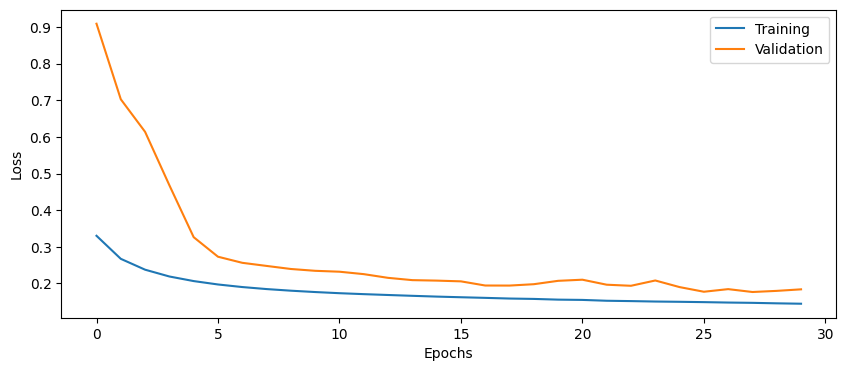

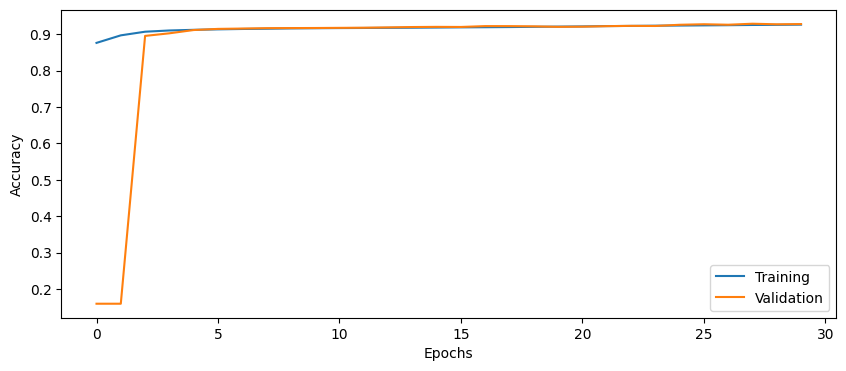

In [85]:
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on.

Question 18: What is the mean and the standard deviation of the test accuracy?

In [11]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [12]:
# Your best training parameters
# Your best training parameters
# the previous best training parameters took too much time so we change it a little bit
batch_size = 10000
epochs = 40
input_shape = X.shape

# Build and train model
model11 = build_DNN(input_shape, n_layers=2, n_nodes=50, use_custom_dropout = True, use_bn = True)

history11 = model11.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size, validation_data=(Xval,Yval))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/40
54/54 [==============================] - 3s 31ms/step - loss: 0.3965 - accuracy: 0.8757 - val_loss: 0.3779 - val_accuracy: 0.8425
Epoch 2/40
54/54 [==============================] - 1s 20ms/step - loss: 0.2651 - accuracy: 0.8932 - val_loss: 0.3485 - val_accuracy: 0.8405
Epoch 3/40
54/54 [==============================] - 1s 27ms/step - loss: 0.2331 - accuracy: 0.8959 - val_loss: 0.3218 - val_accuracy: 0.8410
Epoch 4/40
54/54 [==============================] - 1s 25ms/step - loss: 0.2167 - accuracy: 0.8974 - val_loss: 0.2968 - val_accuracy: 0.8418
Epoch 5/40
54/54 [==============================] - 1s 21ms/step - loss: 0.2069 - accuracy: 0.8986 - val_loss: 0.2617 - val_accuracy: 0.8469
Epoch 6/40
54/54 [==============================] - 1s 23ms/step - loss: 0.2010 - accuracy: 0.

In [13]:
# Run this cell a few times to evalute the model on test data,
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest,Ytest, batch_size=batch_size)


print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 8ms/step - loss: 0.1684 - accuracy: 0.9071
Test accuracy: 0.9071


In [14]:
# Run the testing 100 times, and save the accuracies in an array

accuracy = np.zeros(100)
for i in range(100):
    score = model11.evaluate(Xtest,Ytest, batch_size=batch_size)
    accuracy[i] = score[1]
# Calculate and print mean and std of accuracies

print(f"mean of Accuracy = {np.mean(accuracy)}" )
print(f"standard deviation of Accuracy= {np.std(accuracy)}" )

12/12 [==============================] - 0s 7ms/step - loss: 0.1679 - accuracy: 0.9064


12/12 [==============================] - 0s 7ms/step - loss: 0.1682 - accuracy: 0.9061
mean of Accuracy = 0.9065809071063995
standard deviation of Accuracy= 0.0005685098052432935


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234.

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

*mean of Accuracy in CV = 0.8865321218967438
standard deviation of Accuracy in CV= 0.004191709135100836*


Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

*Dropout reduces the memory burden on the training by dropping out observations. Even with a single modeling dropout can simulate an ensemble model. whereas, in cross validation the whole data is run K-fold times which is computationally intense compared to dropout.*

In [13]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

accuracy=[]

# Loop over cross validation folds
for i, (IndexTrain, IndexTest) in enumerate(cv10.split(X, Y)):
    Xtrain = X[IndexTrain,:]
    Ytrain = Y[IndexTrain]
    Xtest = X[IndexTest,:]
    Ytest = Y[IndexTest]
    
    # Calculate class weights for current split
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Ytrain)
    class_weights = {0: class_weights[0],
                1: class_weights[1]}

    
    # Rebuild the DNN model, to not continue training on the previously trained model
    
    batch_size = 10000
    epochs = 20
    input_shape = X.shape
    modelCV = build_DNN(input_shape, n_layers=2, n_nodes=20)
    
    # Fit the model with training set and class weights for this fold
    
    historyCV = modelCV.fit(Xtrain, Ytrain, verbose = 0, epochs=epochs, batch_size=batch_size, validation_data=(Xval,Yval), class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = modelCV.evaluate(Xtest,Ytest, batch_size=batch_size, verbose = 0)
    
    # Save the test accuracy in an array
    accuracy.append(score[1])
    
# Calculate and print mean and std of accuracies

print(f"mean of Accuracy in CV = {np.mean(accuracy)}" )
print(f"standard deviation of Accuracy in CV= {np.std(accuracy)}" )

2024-04-23 19:52:17.253566: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253082064 exceeds 10% of free system memory.
2024-04-23 19:52:28.290609: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253082064 exceeds 10% of free system memory.
2024-04-23 19:52:38.082255: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253082064 exceeds 10% of free system memory.
2024-04-23 19:52:47.736605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253082064 exceeds 10% of free system memory.
2024-04-23 19:52:57.608338: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 253082064 exceeds 10% of free system memory.


mean of Accuracy in CV = 0.8865321218967438
standard deviation of Accuracy in CV= 0.004191709135100836


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

*For Regression models we wont add an activation function to the output layer. The activation function sigmoid is commonly used for classification purposes. So instead of sigmoid function using linear activation functions like ReLu would ne ideal.*

## Report

Send in this jupyter notebook, with answers to all questions.